In [ ]:
# first time setup only
#!python ./fetch_dataset.py
#!unzip ./frames.zip # only for first time setup

# mount the drive
from google.colab import drive
drive.mount('/content/drive')

# move to the git repo
%cd /content/drive/Shareddrives/StellarSummarizers/the-stellar-summarizers-sp22

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/Shareddrives/StellarSummarizers/the-stellar-summarizers-sp22


950
Data Loader:
Feature batch shape: torch.Size([64, 3, 270, 480])
Labels batch shape: torch.Size([64])
Using: CPU


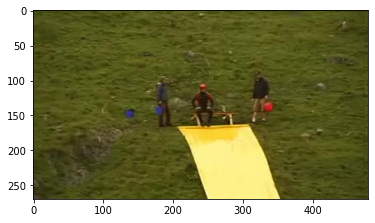

In [ ]:
# from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.io import read_image

import matplotlib.pyplot as plt
import pandas as pd
import os
#import the model for the CNN
import torchvision.models as models


class SumMeDataset(Dataset):
    def __init__(self, annotations_filename, img_dir, transform=None, target_transform=None):

        self.annotation_filename = annotations_filename
        self.annotation = pd.read_csv(annotations_filename, header=0)

        self.img_dir = img_dir
        self.video_name = img_dir.split('/')[-1]
        self.frame_labels = self.annotation[self.annotation['video_name'] == self.video_name]['gt_score']

        # not implemented yet
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frame_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'img_' + str(idx + 1).zfill(5) + '.jpg')
        image = read_image(img_path)
        label = self.frame_labels.iloc[idx]

        # not implemented yet
        if self.transform:
            image = self.transform(ToPILImage()(image.to('cpu')))
        if self.target_transform:
            label = self.target_transform(label)

        return image, label


if __name__ == '__main__':

    annotations_filename = './frames/annotation.csv'
    videos_root = './frames/Jumps'

    # instantiating the dataset
    dataset = SumMeDataset(annotations_filename, videos_root, transform=ToTensor())
    print(len(dataset))

    # data loader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    features, labels = next(iter(dataloader))
    print("Data Loader:")
    print(f"Feature batch shape: {features.size()}")
    print(f"Labels batch shape: {labels.size()}")

    # get device for training
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using: {device.upper()}")

    # demo, shows the 1000th frame of the Bike_Polo video
    sample = dataset[0]
    plt.imshow(sample[0].permute(1, 2, 0))  # put channel data as last dimension
    plt.show()



In [ ]:
class new_resNext(torch.nn.Module):
    def __init__(self, fc_size=2048, large = False, pretrained = True):
        super(new_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)
        self.model.fc = torch.nn.Linear(fc_size,1)
    def forward(self,x):
        x = self.model(x)
        return x
new_resNext = new_resNext()

In [ ]:
dataiter = iter(dataloader)
features, labels = dataiter.next()

# print images
#imshow(torchvision.utils.make_grid(features))
#print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4))

In [ ]:
output_cnn = new_resNext(features)

In [ ]:
features